# Assignment 6-2: Sarsa, Q-Learning and Expected Sarsa

Welcome to Assignment 6-2. In this notebook, you will:

1. Implement Sarsa with $\epsilon$-greedy action selection
2. Implement Q-Learning with $\epsilon$-greedy action selection
3. Implement Expected Sarsa with $\epsilon$-greedy action selection
4. Investigate how these two algorithms behave on Cliff World (described on page 132 of the textbook)

We will provide you with the environment and infrastructure to run an experiment (called the experiment program in RL-Glue). This notebook will provide all the code you need to run your experiment and visualise learning performance.

## Packages

You will need the following libraries for this assignment. We are using:
1. numpy: the fundamental package for scientific computing with Python.
2. scipy: a Python library for scientific and technical computing.
3. matplotlib: library for plotting graphs in Python.
4. RL-Glue: library for reinforcement learning experiments.

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import sem

from env.rl_glue import RLGlue
from env.agent import BaseAgent
from env import cliffworld_env

In [ ]:
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'figure.figsize': [10,5]})

# Sarsa

In this section you will implement and test a Sarsa agent with $\epsilon$-greedy action selection (Section 6.4 in the textbook).

### Implementation

Your job is to implement the updates in the methods agent_step and agent_end. We provide detailed comments in each method describing what your code should do.

In [ ]:
class SarsaAgent(BaseAgent):
    def agent_init(self, agent_init_info):
        """Setup for the agent called when the experiment first starts."""
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_init_info["seed"])

        # Initialize Q-table with zeros
        self.q = np.zeros((self.num_states, self.num_actions))

    def agent_start(self, observation):
        """The first method called when the episode starts."""
        state = observation
        current_q = self.q[state, :]

        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)

        self.prev_state = state
        self.prev_action = action

        return action

    def agent_step(self, reward, observation):
        """A step taken by the agent."""
        state = observation
        current_q = self.q[state, :]

        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)

        # SARSA update rule
        S = self.prev_state
        A = self.prev_action
        self.q[S, A] += self.step_size * (reward + self.discount * self.q[state, action] - self.q[S, A])

        self.prev_state = state
        self.prev_action = action

        return action

    def agent_end(self, reward):
        """Run when the agent terminates."""
        S = self.prev_state
        A = self.prev_action
        self.q[S, A] += self.step_size * (reward - self.q[S, A])

    def argmax(self, q_values):
        """argmax with random tie-breaking."""
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)


## Q-Learning

In this section you will implement and test a Q-Learning agent with $\epsilon$-greedy action selection (Section 6.5 in the textbook).

### Implementation

Your job is to implement the updates in the methods agent_step and agent_end. We provide detailed comments in each method describing what your code should do.

In [ ]:
class QLearningAgent(BaseAgent):
    def agent_init(self, agent_init_info):
        """Setup for the agent called when the experiment first starts."""
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_init_info["seed"])

        self.q = np.zeros((self.num_states, self.num_actions))  # Q-table

    def agent_start(self, observation):
        """Takes the first action based on the initial observation."""
        state = observation
        current_q = self.q[state, :]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)

        self.prev_state = state
        self.prev_action = action

        return action

    def agent_step(self, reward, observation):
        """Takes one step in the environment based on reward and new observation."""
        state = observation
        current_q = self.q[state, :]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)

        # Q-learning update
        S = self.prev_state
        A = self.prev_action
        self.q[S, A] += self.step_size * (
            reward + self.discount * np.max(current_q) - self.q[S, A]
        )

        self.prev_state = state
        self.prev_action = action

        return action

    def agent_end(self, reward):
        """Handles the final update when the episode ends."""
        S = self.prev_state
        A = self.prev_action
        self.q[S, A] += self.step_size * (reward - self.q[S, A])

    def argmax(self, q_values):
        """argmax with random tie-breaking"""
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)


# Expected Sarsa

In this section you will implement an Expected Sarsa agent with $\epsilon$-greedy action selection (Section 6.6 in the textbook).

### Implementation

Your job is to implement the updates in the methods agent_step and agent_end. We provide detailed comments in each method describing what your code should do.

In [ ]:
class ExpectedSarsaAgent(BaseAgent):
    def agent_init(self, agent_init_info):
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_init_info["seed"])
        self.q = np.zeros((self.num_states, self.num_actions))

    def agent_start(self, state):
        current_q = self.q[state, :]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        self.prev_state = state
        self.prev_action = action
        return action

    def agent_step(self, reward, state):
        current_q = self.q[state, :]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)

        policy = np.ones(self.num_actions) * (self.epsilon / self.num_actions)
        best_action = np.argmax(self.q[state])
        policy[best_action] += (1 - self.epsilon)

        expected_value = np.dot(self.q[state], policy)

        self.q[self.prev_state, self.prev_action] += self.step_size * (
            reward + self.discount * expected_value - self.q[self.prev_state, self.prev_action]
        )

        self.prev_state = state
        self.prev_action = action
        return action

    def agent_end(self, reward):
        self.q[self.prev_state, self.prev_action] += self.step_size * (
            reward - self.q[self.prev_state, self.prev_action]
        )

    def argmax(self, q_values):
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)


In [ ]:
agent_info = {"num_actions": 4, "num_states": 3, "epsilon": 0.1, "step_size": 0.1, "discount": 1.0, "seed": 0}
current_agent = ExpectedSarsaAgent()
current_agent.agent_init(agent_info)
action = current_agent.agent_start(0)
print("Action Value Estimates: \n", current_agent.q)
print("Action:", action)

Action Value Estimates: 
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Action: 1


# Solving the Cliff World

We described the Cliff World environment in the prvious lab assignement. This is an undiscounted episodic task and thus we set $\gamma=1$. The agent starts in the bottom left corner of the gridworld below and takes actions that move it in the four directions. Actions that would move the agent off of the cliff incur a reward of -100 and send the agent back to the start state. The reward for all other transitions is -1. An episode terminates when the agent reaches the bottom right corner.

<img src="cliffworld.png" alt="Drawing" style="width: 600px;"/>


Using the experiment program in the cell below we now compare the agents on the Cliff World environment and plot the sum of rewards during each episode for the two agents.

100%|██████████| 100/100 [00:21<00:00,  4.55it/s]


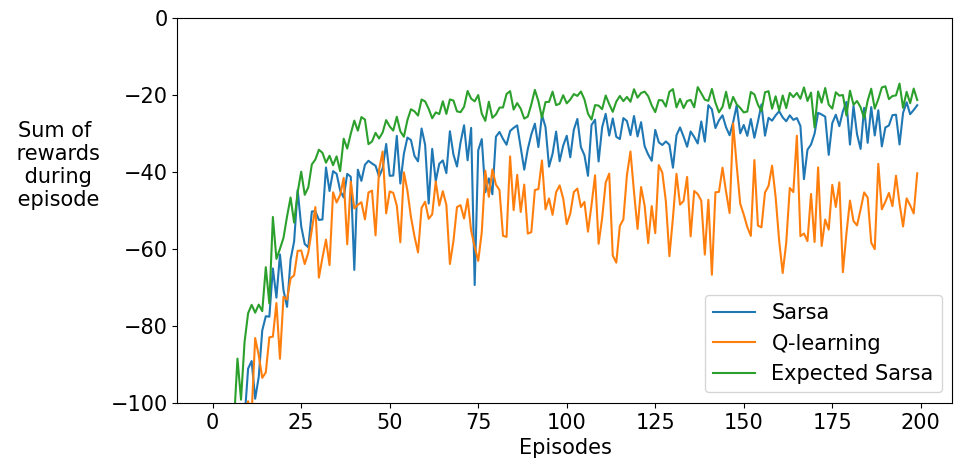

In [ ]:
np.random.seed(0)

agents = {
    "Sarsa": SarsaAgent,
    "Q-learning": QLearningAgent,
    "Expected Sarsa": ExpectedSarsaAgent
}
env = cliffworld_env.Environment
all_reward_sums = {} # Contains sum of rewards during episode
all_state_visits = {} # Contains state visit counts during the last 10 episodes
agent_info = {"num_actions": 4, "num_states": 48, "epsilon": 0.1, "step_size": 0.5, "discount": 1.0}
env_info = {}
num_runs = 100 # The number of runs
num_episodes = 200 # The number of episodes in each run

for algorithm in ["Sarsa", "Q-learning", "Expected Sarsa"]:
    all_reward_sums[algorithm] = []
    all_state_visits[algorithm] = []
    for run in tqdm(range(num_runs)):
        agent_info["seed"] = run
        rl_glue = RLGlue(env, agents[algorithm])
        rl_glue.rl_init(agent_info, env_info)

        reward_sums = []
        state_visits = np.zeros(48)
        for episode in range(num_episodes):
            if episode < num_episodes - 10:
                # Runs an episode
                rl_glue.rl_episode(10000)
            else:
                # Runs an episode while keeping track of visited states
                # YOUR CODE HERE
                state, action = rl_glue.rl_start()
                state_visits[state] += 1
                is_terminal = False
                while not is_terminal:
                    reward, state, action, is_terminal = rl_glue.rl_step()
                    state_visits[state] += 1

            reward_sums.append(rl_glue.rl_return())

        all_reward_sums[algorithm].append(reward_sums)
        all_state_visits[algorithm].append(state_visits)

# plot results
for algorithm in ["Sarsa", "Q-learning", "Expected Sarsa"]:
    plt.plot(np.mean(all_reward_sums[algorithm], axis=0), label=algorithm)
plt.xlabel("Episodes")
plt.ylabel("Sum of\n rewards\n during\n episode",rotation=0, labelpad=40)
plt.ylim(-100,0)
plt.legend()
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:19<00:00,  5.25it/s]


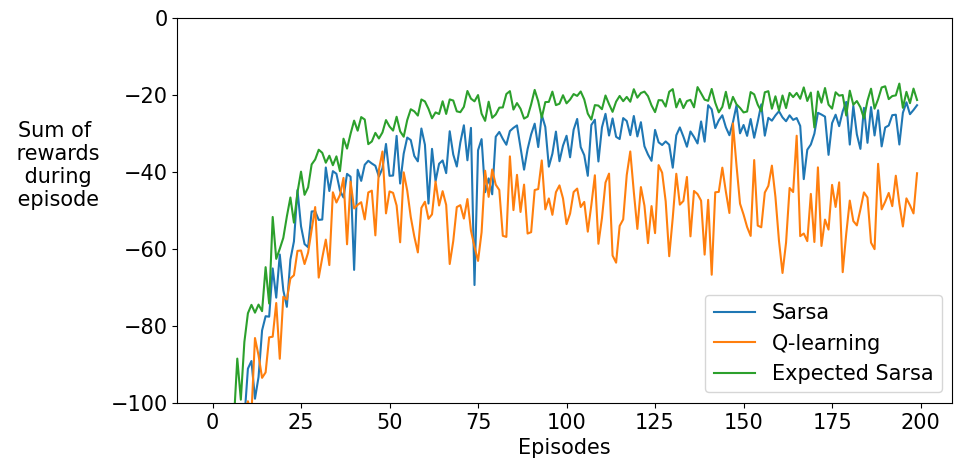

In [ ]:
np.random.seed(0)

agents = {
    "Sarsa": SarsaAgent,
    "Q-learning": QLearningAgent,
    "Expected Sarsa": ExpectedSarsaAgent
}
env = cliffworld_env.Environment
all_reward_sums = {} # Contains sum of rewards during episode
all_state_visits = {} # Contains state visit counts during the last 10 episodes
agent_info = {"num_actions": 4, "num_states": 48, "epsilon": 0.1, "step_size": 0.5, "discount": 1.0}
env_info = {}
num_runs = 100 # The number of runs
num_episodes = 200 # The number of episodes in each run

for algorithm in ["Sarsa", "Q-learning", "Expected Sarsa"]:
    all_reward_sums[algorithm] = []
    all_state_visits[algorithm] = []
    for run in tqdm(range(num_runs)):
        agent_info["seed"] = run
        rl_glue = RLGlue(env, agents[algorithm])
        rl_glue.rl_init(agent_info, env_info)

        reward_sums = []
        state_visits = np.zeros(48)
        for episode in range(num_episodes):
            if episode < num_episodes - 10:
                # Runs an episode
                rl_glue.rl_episode(10000)
            else:
                # Runs an episode while keeping track of visited states
                # YOUR CODE HERE
                state, action = ...
                state_visits[state] = ...
                is_terminal = False
                while not is_terminal:
                    reward, state, action, is_terminal = ...
                    state_visits[state] = ...

            reward_sums.append(rl_glue.rl_return())

        all_reward_sums[algorithm].append(reward_sums)
        all_state_visits[algorithm].append(state_visits)

# plot results
for algorithm in ["Sarsa", "Q-learning", "Expected Sarsa"]:
    plt.plot(np.mean(all_reward_sums[algorithm], axis=0), label=algorithm)
plt.xlabel("Episodes")
plt.ylabel("Sum of\n rewards\n during\n episode",rotation=0, labelpad=40)
plt.ylim(-100,0)
plt.legend()
plt.show()

To see why these two agents behave differently, let's inspect the states they visit most. Run the cell below to generate plots showing the number of timesteps that the agents spent in each state over the last 10 episodes.

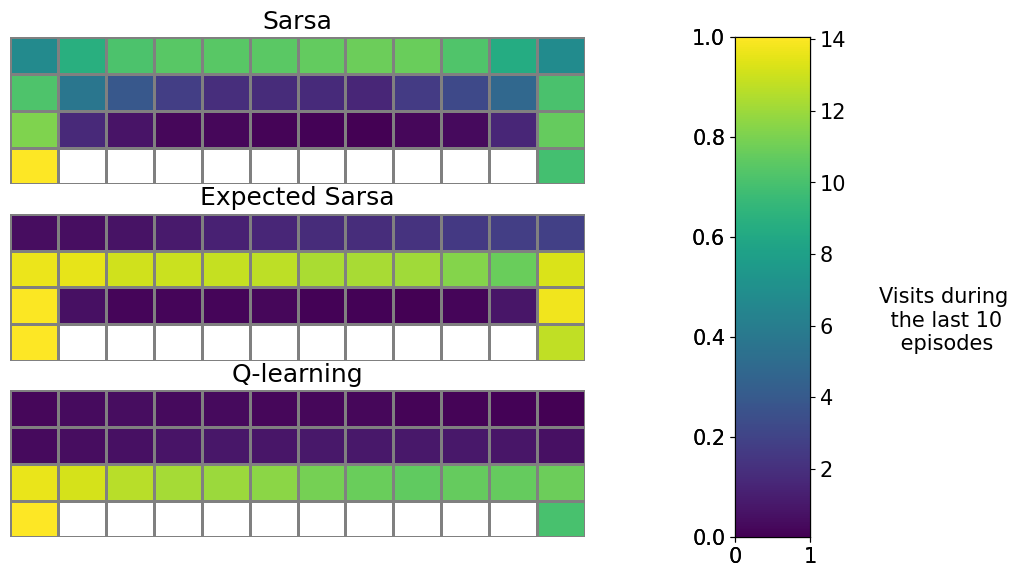

In [ ]:
for algorithm, position in [("Sarsa", 311), ("Expected Sarsa", 312), ("Q-learning", 313)]:
    plt.subplot(position)
    average_state_visits = np.array(all_state_visits[algorithm]).mean(axis=0)
    grid_state_visits = average_state_visits.reshape((4,12))
    grid_state_visits[0,1:-1] = np.nan
    plt.pcolormesh(grid_state_visits, edgecolors='gray', linewidth=2)
    plt.title(algorithm)
    plt.axis('off')
    cm = plt.get_cmap()
    cm.set_bad('gray')

    plt.subplots_adjust(bottom=0.0, right=0.7, top=1.0)
    cax = plt.axes([0.85, 0.0, 0.075, 1.])

cbar = plt.colorbar(cax=cax)
cbar.ax.set_ylabel("Visits during\n the last 10\n episodes", rotation=0, labelpad=70)
plt.show()

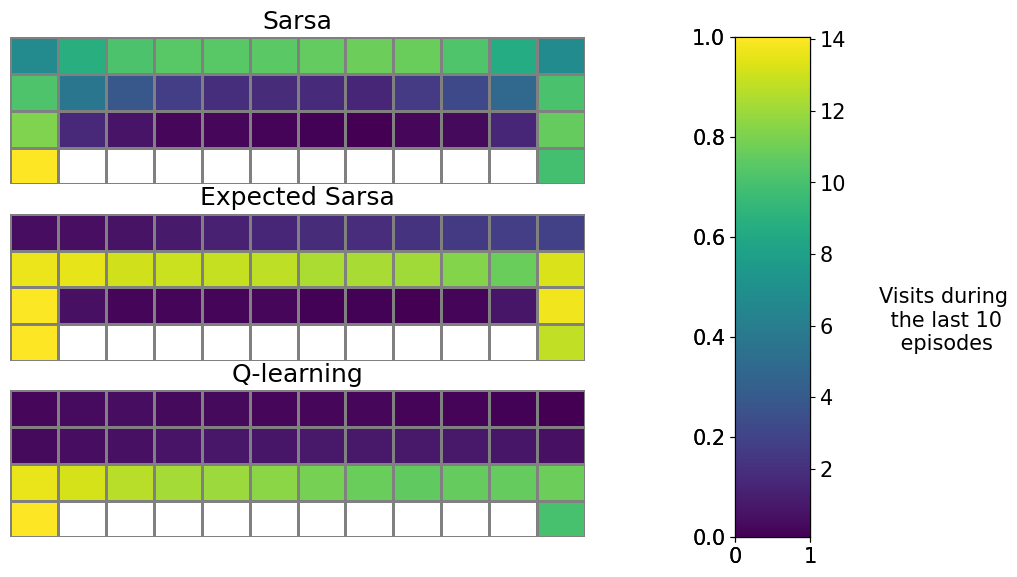

In [ ]:
for algorithm, position in [("Sarsa", 311), ("Expected Sarsa", 312), ("Q-learning", 313)]:
    plt.subplot(position)
    average_state_visits = np.array(all_state_visits[algorithm]).mean(axis=0)
    grid_state_visits = average_state_visits.reshape((4,12))
    grid_state_visits[0,1:-1] = np.nan
    plt.pcolormesh(grid_state_visits, edgecolors='gray', linewidth=2)
    plt.title(algorithm)
    plt.axis('off')
    cm = plt.get_cmap()
    cm.set_bad('gray')

    plt.subplots_adjust(bottom=0.0, right=0.7, top=1.0)
    cax = plt.axes([0.85, 0.0, 0.075, 1.])

cbar = plt.colorbar(cax=cax)
cbar.ax.set_ylabel("Visits during\n the last 10\n episodes", rotation=0, labelpad=70)
plt.show()

**Question:**

Based on the obtained visualizations , what insights can you draw from comparing the performance of Sarsa, Q-learning, and Expected Sarsa algorithms on the cliff-walking problem?

**Answer:**

Q-learning tends to achieve the highest average return over time compared to the other algorithms, especially at moderate-to-high step-sizes.

However, Q-learning often takes the risky path near the cliff to reach the goal quickly, and due to ε-greedy exploration, it frequently falls off the cliff, resulting in large negative rewards.

Expected Sarsa incorporates the expected value over actions, which leads to more cautious and stable behavior, avoiding the cliff more consistently.

Sarsa lies somewhere in between—learning a safer policy than Q-learning but less optimal in terms of reaching the goal quickly.

# Evaluating Step-Size Impact on Agent Performance

Previously we used a fixed step-size of 0.5 for the agents. What happens with other step-sizes? Does this difference in performance persist?

In the next experiment we will try 10 different step-sizes from 0.1 to 1.0 and compare the sum of rewards per episode averaged over the first 100 episodes (similar to the interim performance curves in Figure 6.3 of the textbook). Shaded regions show standard errors.

100%|██████████| 900/900 [02:35<00:00,  5.79it/s]


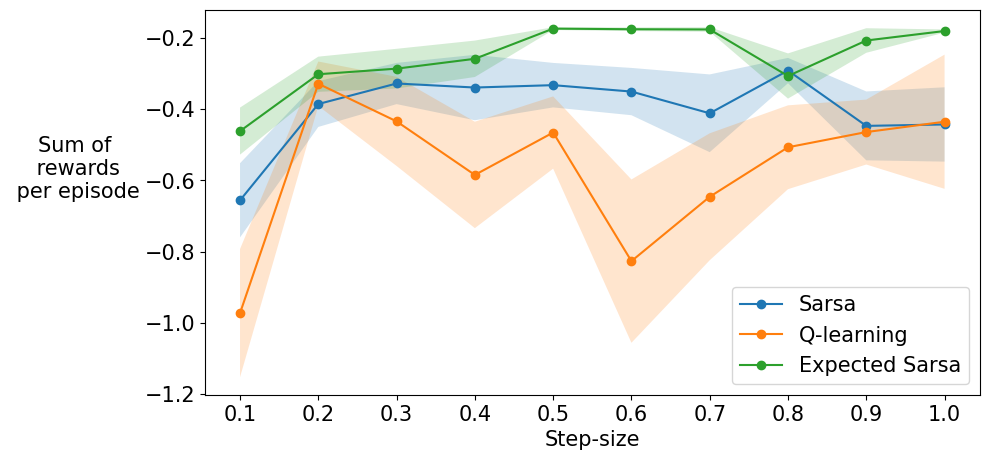

In [ ]:
from itertools import product

agents = {
    "Sarsa": SarsaAgent,
    "Q-learning": QLearningAgent,
    "Expected Sarsa": ExpectedSarsaAgent
}

env = cliffworld_env.Environment

all_reward_sums = {}
step_sizes = np.linspace(0.1,1.0,10)
agent_info = {"num_actions": 4, "num_states": 48, "epsilon": 0.1, "discount": 1.0}
env_info = {}
num_runs = 30
num_episodes = 100
all_reward_sums = {}

algorithms = ["Sarsa", "Q-learning", "Expected Sarsa"]
cross_product = list(product(algorithms, step_sizes, range(num_runs)))
for algorithm, step_size, run in tqdm(cross_product):
    if (algorithm, step_size) not in all_reward_sums:
        all_reward_sums[(algorithm, step_size)] = []

    agent_info["step_size"] = step_size
    agent_info["seed"] = run
    rl_glue = RLGlue(env, agents[algorithm])
    rl_glue.rl_init(agent_info, env_info)

    last_episode_total_reward = 0
    for episode in range(num_episodes):
        rl_glue.rl_episode(0)
    all_reward_sums[(algorithm, step_size)].append(rl_glue.rl_return()/num_episodes)


for algorithm in ["Sarsa", "Q-learning", "Expected Sarsa"]:
    algorithm_means = np.array([np.mean(all_reward_sums[(algorithm, step_size)]) for step_size in step_sizes])
    algorithm_stds = np.array([sem(all_reward_sums[(algorithm, step_size)]) for step_size in step_sizes])
    plt.plot(step_sizes, algorithm_means, marker='o', linestyle='solid', label=algorithm)
    plt.fill_between(step_sizes, algorithm_means + algorithm_stds, algorithm_means - algorithm_stds, alpha=0.2)

plt.legend()
plt.xlabel("Step-size")
plt.ylabel("Sum of\n rewards\n per episode",rotation=0, labelpad=50)
plt.xticks(step_sizes)
plt.show()

100%|██████████| 900/900 [01:57<00:00,  7.68it/s]


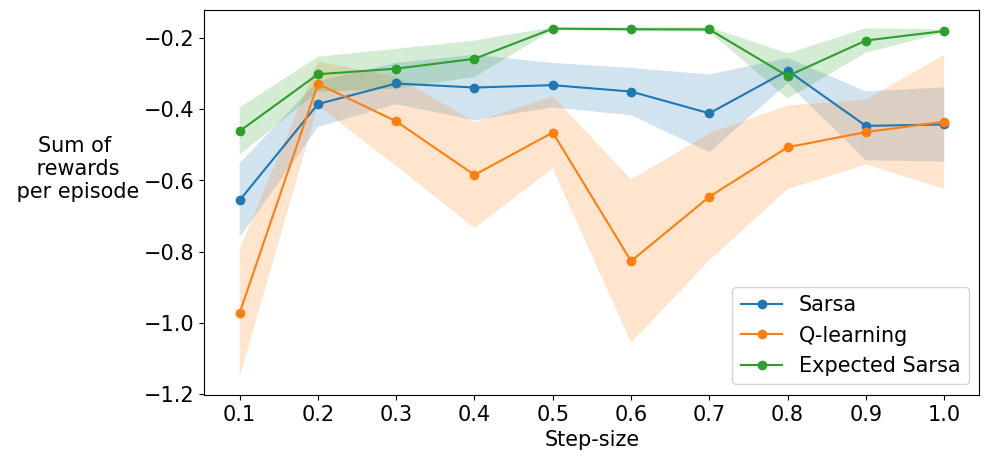

In [ ]:
from itertools import product

agents = {
    "Sarsa": SarsaAgent,
    "Q-learning": QLearningAgent,
    "Expected Sarsa": ExpectedSarsaAgent
}

env = cliffworld_env.Environment

all_reward_sums = {}
step_sizes = np.linspace(0.1,1.0,10)
agent_info = {"num_actions": 4, "num_states": 48, "epsilon": 0.1, "discount": 1.0}
env_info = {}
num_runs = 30
num_episodes = 100
all_reward_sums = {}

algorithms = ["Sarsa", "Q-learning", "Expected Sarsa"]
cross_product = list(product(algorithms, step_sizes, range(num_runs)))
for algorithm, step_size, run in tqdm(cross_product):
    if (algorithm, step_size) not in all_reward_sums:
        all_reward_sums[(algorithm, step_size)] = []

    agent_info["step_size"] = step_size
    agent_info["seed"] = run
    rl_glue = RLGlue(env, agents[algorithm])
    rl_glue.rl_init(agent_info, env_info)

    last_episode_total_reward = 0
    for episode in range(num_episodes):
        rl_glue.rl_episode(0)
    all_reward_sums[(algorithm, step_size)].append(rl_glue.rl_return()/num_episodes)


for algorithm in ["Sarsa", "Q-learning", "Expected Sarsa"]:
    algorithm_means = np.array([np.mean(all_reward_sums[(algorithm, step_size)]) for step_size in step_sizes])
    algorithm_stds = np.array([sem(all_reward_sums[(algorithm, step_size)]) for step_size in step_sizes])
    plt.plot(step_sizes, algorithm_means, marker='o', linestyle='solid', label=algorithm)
    plt.fill_between(step_sizes, algorithm_means + algorithm_stds, algorithm_means - algorithm_stds, alpha=0.2)

plt.legend()
plt.xlabel("Step-size")
plt.ylabel("Sum of\n rewards\n per episode",rotation=0, labelpad=50)
plt.xticks(step_sizes)
plt.show()

100%|██████████| 900/900 [13:52<00:00,  1.08it/s]


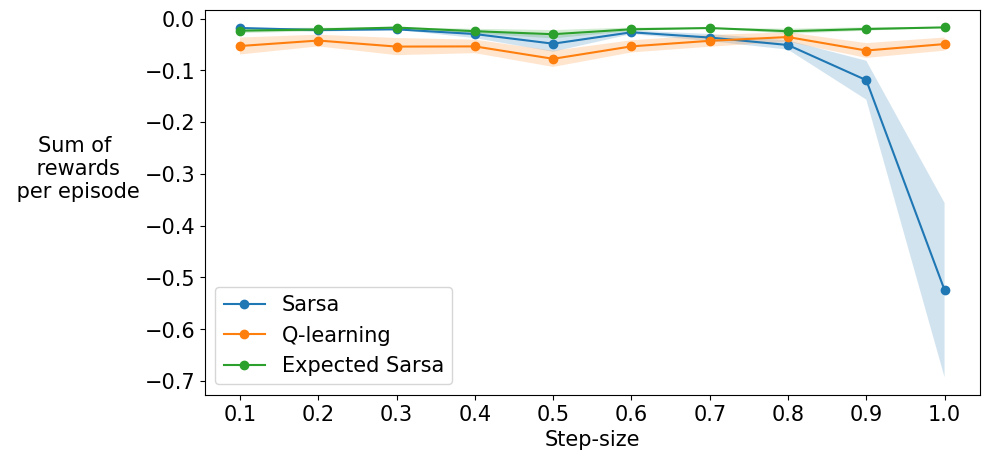

In [ ]:
from itertools import product

agents = {
    "Sarsa": SarsaAgent,
    "Q-learning": QLearningAgent,
    "Expected Sarsa": ExpectedSarsaAgent
}

env = cliffworld_env.Environment

all_reward_sums = {}
step_sizes = np.linspace(0.1,1.0,10)
agent_info = {"num_actions": 4, "num_states": 48, "epsilon": 0.1, "discount": 1.0}
env_info = {}
num_runs = 30
num_episodes = 1000
all_reward_sums = {}

algorithms = ["Sarsa", "Q-learning", "Expected Sarsa"]
cross_product = list(product(algorithms, step_sizes, range(num_runs)))
for algorithm, step_size, run in tqdm(cross_product):
    if (algorithm, step_size) not in all_reward_sums:
        all_reward_sums[(algorithm, step_size)] = []

    agent_info["step_size"] = step_size
    agent_info["seed"] = run
    rl_glue = RLGlue(env, agents[algorithm])
    rl_glue.rl_init(agent_info, env_info)

    last_episode_total_reward = 0
    for episode in range(num_episodes):
        rl_glue.rl_episode(0)
    all_reward_sums[(algorithm, step_size)].append(rl_glue.rl_return()/num_episodes)


for algorithm in ["Sarsa", "Q-learning", "Expected Sarsa"]:
    algorithm_means = np.array([np.mean(all_reward_sums[(algorithm, step_size)]) for step_size in step_sizes])
    algorithm_stds = np.array([sem(all_reward_sums[(algorithm, step_size)]) for step_size in step_sizes])
    plt.plot(step_sizes, algorithm_means, marker='o', linestyle='solid', label=algorithm)
    plt.fill_between(step_sizes, algorithm_means + algorithm_stds, algorithm_means - algorithm_stds, alpha=0.2)

plt.legend()
plt.xlabel("Step-size")
plt.ylabel("Sum of\n rewards\n per episode",rotation=0, labelpad=50)
plt.xticks(step_sizes)
plt.show()

100%|██████████| 900/900 [10:30<00:00,  1.43it/s]


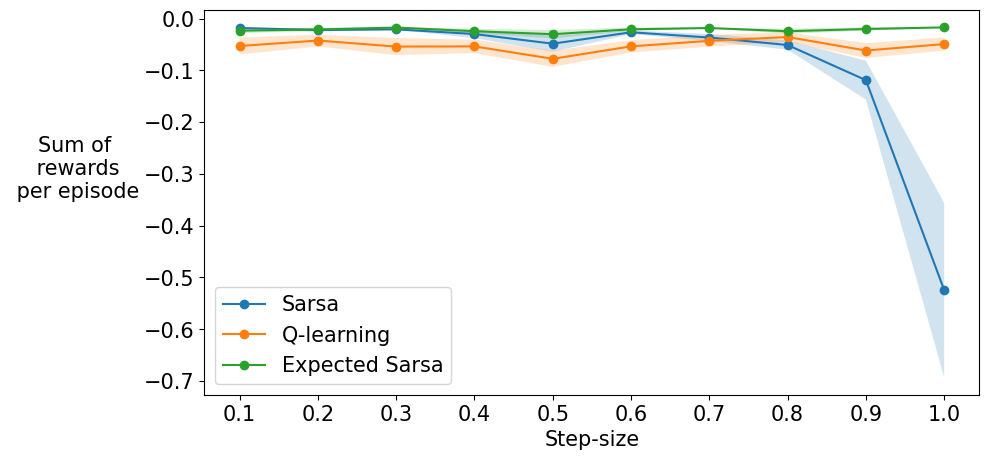

In [ ]:
from itertools import product

agents = {
    "Sarsa": SarsaAgent,
    "Q-learning": QLearningAgent,
    "Expected Sarsa": ExpectedSarsaAgent
}

env = cliffworld_env.Environment

all_reward_sums = {}
step_sizes = np.linspace(0.1,1.0,10)
agent_info = {"num_actions": 4, "num_states": 48, "epsilon": 0.1, "discount": 1.0}
env_info = {}
num_runs = 30
num_episodes = 1000
all_reward_sums = {}

algorithms = ["Sarsa", "Q-learning", "Expected Sarsa"]
cross_product = list(product(algorithms, step_sizes, range(num_runs)))
for algorithm, step_size, run in tqdm(cross_product):
    if (algorithm, step_size) not in all_reward_sums:
        all_reward_sums[(algorithm, step_size)] = []

    agent_info["step_size"] = step_size
    agent_info["seed"] = run
    rl_glue = RLGlue(env, agents[algorithm])
    rl_glue.rl_init(agent_info, env_info)

    last_episode_total_reward = 0
    for episode in range(num_episodes):
        rl_glue.rl_episode(0)
    all_reward_sums[(algorithm, step_size)].append(rl_glue.rl_return()/num_episodes)


for algorithm in ["Sarsa", "Q-learning", "Expected Sarsa"]:
    algorithm_means = np.array([np.mean(all_reward_sums[(algorithm, step_size)]) for step_size in step_sizes])
    algorithm_stds = np.array([sem(all_reward_sums[(algorithm, step_size)]) for step_size in step_sizes])
    plt.plot(step_sizes, algorithm_means, marker='o', linestyle='solid', label=algorithm)
    plt.fill_between(step_sizes, algorithm_means + algorithm_stds, algorithm_means - algorithm_stds, alpha=0.2)

plt.legend()
plt.xlabel("Step-size")
plt.ylabel("Sum of\n rewards\n per episode",rotation=0, labelpad=50)
plt.xticks(step_sizes)
plt.show()

**Question:**

What does the experiment comparing Expected Sarsa, Sarsa, and Q-learning on the Cliff World task reveal about their relative performance and sensitivity to the step-size parameter $\alpha$?

**Answer:**

Q-learning learns the optimal path but is risky and sensitive to the step-size; it often falls off the cliff due to aggressive updates.

Sarsa takes a safer, more conservative path, avoiding the cliff but sacrificing speed and optimality.

Expected Sarsa strikes a balance — it's safer than Q-learning and performs better than Sarsa, showing stable and robust performance across different step-sizes.

Step-size Sensitivity: Expected Sarsa is the least sensitive, while Q-learning is the most sensitive to step-size changes.

Congratulations! You’ve successfully completed this lab assignment. Along the way, you have:

- Implemented SARSA with $\epsilon$-greedy action selection  
- Implemented Q-Learning with $\epsilon$-greedy action selection  
- Implemented Expected SARSA with $\epsilon$-greedy action selection  
- Explored and compared the behavior of these algorithms in the Cliff World environment